In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import theano
import theano.tensor as tt
import os
import utils
import make_data
from scipy.linalg import block_diag
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Settings

In [2]:
dz_f = 0.01
z_max = 2.5
z_arr_f = np.arange(0.0, z_max+0.1, dz_f)
a_arr_f = 1/(1+z_arr_f) 
x_arr_f = np.log(a_arr_f)
path = '/home/jaimerz/PhD/Growz/data/products'

tools = utils.utils()
c = tools.c
data = make_data.make_data(z_max, 2, path)


DESI = data.get_DESI(new=True)
WFIRST = data.get_WFIRST(new=True)
CC = data.get_CC(new=True)
DSS = data.get_DSS(new=True)
BOSS = data.get_BOSS(new=True)
eBOSS = data.get_eBOSS(new=True)
Wigglez = data.get_Wigglez(new=True)
DS17 = data.get_DS17(new=True)

In [3]:
Planck = tools.get_preds(z_arr_f, mode='Planck')

n_samples = 10000
n_tune = 10000
datadict = {'DESI': DESI,
            'WFIRST': WFIRST,
            'CC': CC,
            'DS17': DS17, 
            'BOSS': BOSS,
            'eBOSS': eBOSS,
            'Wigglez': Wigglez,
            'DSS': DSS}

datasets = ['DS17']

need_dM = ['DESI', 'BOSS', 'eBOSS', 'Wigglez', 'DS17']
need_fs8 = ['DESI', 'BOSS', 'eBOSS', 'Wigglez', 'DSS']
if any(dataset in datasets for dataset in need_dM):
    get_dM=True 
else:
    get_dM=False
if any(dataset in datasets for dataset in need_fs8):
    get_fs8=True
else:
    get_fs8=False

In [4]:
data = np.array([])
data_cov = np.array([])
for dataset_name in datasets:
    dataset = datadict[dataset_name]
    data = np.concatenate([data, dataset['data']])
    data_cov = block_diag(data_cov, dataset['cov'])
data_cov = data_cov [1:]

# Plotting

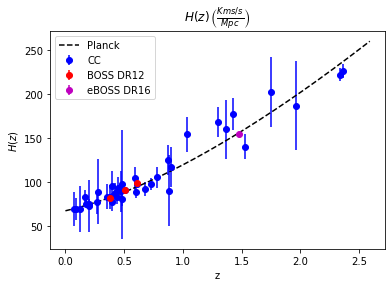

In [5]:
plt.plot(z_arr_f, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS DR16')


# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_data.pdf')  

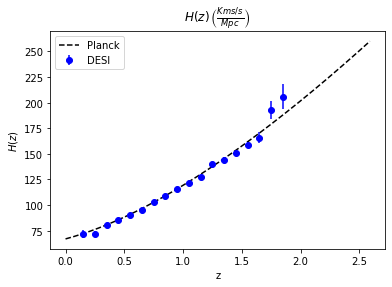

In [6]:
plt.plot(z_arr_f, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], DESI['H_data'], yerr = DESI['H_err'], fmt='bo', label='DESI')


# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_forecast.pdf')  

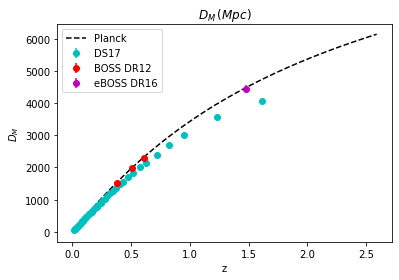

In [7]:
plt.plot(z_arr_f, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.2)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS DR16')

# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')  

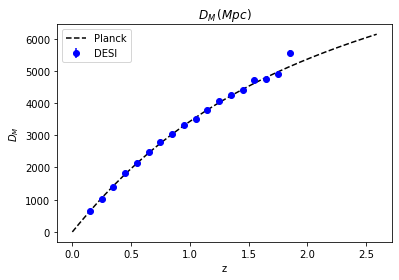

In [8]:
plt.plot(z_arr_f, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], (1+DESI['z'])*DESI['dA_data'], yerr=DESI['dA_err'], fmt='bo', label='DESI')

# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_forecast.pdf')  

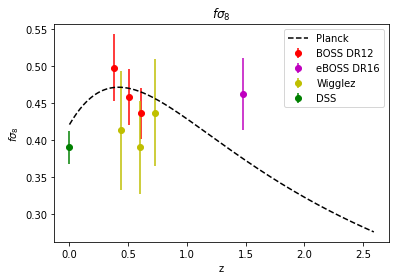

In [9]:
plt.plot(z_arr_f, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(BOSS['z'], BOSS['fs8_data'], yerr=BOSS['fs8_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['fs8_data'], yerr=eBOSS['fs8_err'], fmt='mo', label='eBOSS DR16')
plt.errorbar(Wigglez['z'], Wigglez['data'], yerr=Wigglez['err'], fmt='yo', label='Wigglez')
plt.errorbar(DSS['z'], DSS['data'], yerr=DSS['err'], fmt='go', label='DSS')


# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_data.pdf')  

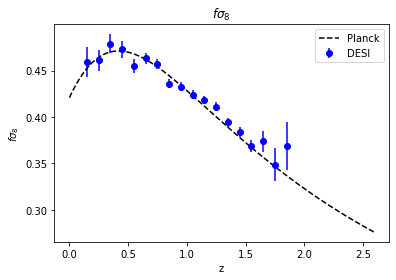

In [10]:
plt.plot(z_arr_f, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], DESI['fs8_data'], yerr=DESI['fs8_err'], fmt='bo', label='DESI')


# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_forecast.pdf')  

# Model

In [11]:
with pm.Model() as model:
    ℓ = pm.InverseGamma("ℓ", alpha=1, beta=100) 
    η = pm.Exponential("η", lam=1/20) 
    H0 = pm.Normal('H0', mu=70 , sigma=5)
    H1 = pm.Normal('H1', mu=35 , sigma=5)
    H2 = pm.Normal('H2', mu=35 , sigma=5)
    Wm0 = pm.Uniform("Wm0", 0., 1.) 
    Df = pm.Normal("Df", mu=0.05, sigma=0.05) 
    s80 = pm.Normal("s80", 0.8, 0.5)
    gp_cov = η ** 2 * pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-3)
    gp = pm.gp.Latent(cov_func=gp_cov)
    
    #Mean of the gp
    H_f = pm.Deterministic('H_f',
               tt.as_tensor_variable(H0+H1*z_arr_f+(1/2)*H2*z_arr_f**2))
    
    #Set up Gaussian process
    DH_gp_f = gp.prior("DH_gp_f", X=z_arr_f[:, None]) 
    H_gp_f = pm.Deterministic("H_gp_f", tt.as_tensor_variable(DH_gp_f+H_f)) 
    H0_gp = pm.Deterministic("H0_gp", tt.as_tensor_variable(H_gp_f[0]))
    
    if get_dM:
        dH_gp_f = pm.Deterministic("dH_f", tt.as_tensor_variable((c/1000)/H_gp_f))
        dM_gp_f = tt.zeros(len(z_arr_f))
        dM_gp_f = tt.inc_subtensor(dM_gp_f[1:],
                  tt.as_tensor_variable(dz_f*tt.cumsum(dH_gp_f)[:-1]))
        dM_gp_f = pm.Deterministic('dM_gp_f', dM_gp_f)
        dA_gp_f = pm.Deterministic('dA_gp_f', dM_gp_f/(1+z_arr_f))
        dL_gp_f = pm.Deterministic('dL_gp_f', dM_gp_f*(1+z_arr_f))
    
    if get_fs8:
        #Second order differentiation scheme
        Wm =  pm.Deterministic("Wm", Wm0*(H0_gp/H_gp_f)**2*(1+z_arr_f)**3)
        comf_H = pm.Deterministic("comf_H", a_arr_f*H_gp_f)
        diff_comf_H = tt.zeros(len(z_arr_f))
        diff_comf_H = tt.inc_subtensor(diff_comf_H[0], (comf_H[1]-comf_H[0])/(x_arr_f[1]-x_arr_f[0]))
        diff_comf_H = tt.inc_subtensor(diff_comf_H[1:-1], (comf_H[2:]-comf_H[:-2])/(x_arr_f[2:]-x_arr_f[:-2]))
        diff_comf_H = tt.inc_subtensor(diff_comf_H[-1], (comf_H[-1]-comf_H[-2])/(x_arr_f[-1]-x_arr_f[-2]))
        diff_comf_H  = pm.Deterministic("diff_comf_H", diff_comf_H)
        q = 1+(diff_comf_H/comf_H)

        #Implement second Order Runge-Kutta method
        f0 = pm.Deterministic('f0', 1-Df) 
        f_gp_f = tt.zeros(len(z_arr_f))
        f_gp_f = tt.inc_subtensor(f_gp_f[-1], f0)
        for i in np.arange(1, len(z_arr_f)):
            k0 = (-1/(1+z_arr_f[-i]))*((3/2)*Wm[-i]-f_gp_f[-i]**2-q[-i]*f_gp_f[-i])
            f1 = f_gp_f[-i]-dz_f*k0
            k1 = (-1/(1+z_arr_f[-(i+1)]))*((3/2)*Wm[-(i+1)]-f1**2-q[-(i+1)]*f1)
            f_gp_f = tt.inc_subtensor(f_gp_f[-(i+1)], f_gp_f[-i]-dz_f*(k1+k0)/2)
        f_gp_f = pm.Deterministic("f_gp_f", f_gp_f) 

        #integrate for s8 method2
        s8_gp_f = tt.zeros(len(z_arr_f))
        s8_gp_f = tt.inc_subtensor(s8_gp_f[0], s80)
        for i in np.arange(1, len(z_arr_f)):
            k0 = -1*(f_gp_f[i-1]*s8_gp_f[i-1])/(1+z_arr_f[i-1])
            s8_gp_f = tt.inc_subtensor(s8_gp_f[i], s8_gp_f[i-1] + dz_f*(k0))
        s8_gp_f = pm.Deterministic("s8_gp_f", s8_gp_f) 

        fs8_gp_f = f_gp_f*s8_gp_f
        fs8_gp_f = pm.Deterministic("fs8_gp_f", fs8_gp_f)
    
    theory = tt.as_tensor_variable([])

In [ ]:
if 'DESI' in datasets:
    print('Adding DESI')
    with model:
        DESI_H = pm.Deterministic('DESI_H', tt.as_tensor_variable(H_gp_f[DESI['idx']]))
        DESI_dA = pm.Deterministic('DESI_dA', tt.as_tensor_variable(dA_gp_f[DESI['idx']]))
        DESI_fs8 = pm.Deterministic('DESI_fs8', tt.as_tensor_variable(fs8_gp_f[DESI['idx']]))
        theory = tt.concatenate([theory, DESI_H, DESI_dA, DESI_fs8])
        
if 'WFIRST' in datasets:
    print('Adding WFIRST')
    with model:
        E_gp_f = pm.Deterministic("E_gp_f", tt.as_tensor_variable(H_gp_f/H0_gp)) 
        WFIRST_E = pm.Deterministic('WFIRST_E', tt.as_tensor_variable(E_gp_f[WFIRST['idx']]))
        theory = tt.concatenate([theory, WFIRST_E])

if 'CC' in datasets:
    print('Adding CCs')
    with model:
        CC_H = pm.Deterministic("CC_H",
               tt.as_tensor_variable(H_gp_f[CC['idx']]+(H_gp_f[CC['idx']+1]-H_gp_f[CC['idx']])*(CC['z']-z_arr_f[CC['idx']])/dz_f))
        theory = tt.concatenate([theory, CC_H])
        
if 'DS17' in datasets:
    print('Adding Pantheon')
    with model:
        M = pm.Normal('M', mu=-19.0, sigma=1)
        u_gp_f = pm.Deterministic('u_gp_f', tt.as_tensor_variable(5*tt.log10(dL_gp_f)+25+M))
        DS17_u = pm.Deterministic("DS17_u",
                 tt.as_tensor_variable(u_gp_f[DS17['idx']]+(u_gp_f[DS17['idx']+1]-u_gp_f[DS17['idx']])*(DS17['z']-z_arr_f[DS17['idx']])/dz_f))
        theory = tt.concatenate([theory, DS17_u])
        
if 'BOSS' in datasets:
    print('Adding BOSS')
    with model:
        Wb0 = pm.Uniform("Wb0", 0., 1.) 
        h = pm.Deterministic('h', H0_gp/100) 
        wm0 = pm.Deterministic("wm0", Wm0*h**2)
        wb0 = pm.Deterministic("wb0", Wb0*h**2)
        theta27 = 2.755/2.7 
        zeq =  2.5 * 10**4 * wm0 * theta27**-4 
        keq = 7.46 * 10**-2 * wm0 * theta27**-2
        b1 = 0.313 * wm0**(-0.419) * (1 + 0.607 * wm0**(0.674))
        b2 = 0.238 * wm0**(0.223)
        zd = 1291 * ((wm0**0.251)/(1+0.659*wm0**0.828)) * (1+ b1*wb0**b2)
        Rd = 31.5 * wb0 * theta27**-4 * (zd/10*3)**-1
        Req = 31.5 * wb0 * theta27**-4 * (zeq/10*3)**-1
        rd_gp = pm.Deterministic('rd_gp',(2/(3*keq))*tt.sqrt(6/Req)*tt.log((tt.sqrt(1+Rd)+tt.sqrt(Rd+Req))/(1+tt.sqrt(Req))))

        #Get alpha_perp and alpha_para 
        BOSS_para_f = pm.Deterministic("BOSS_para_f", H_gp_f*rd_gp/BOSS['rd'])
        BOSS_perp_f = pm.Deterministic("BOSS_perp_f", dM_gp_f*BOSS['rd']/rd_gp)
        
        BOSS_para = pm.Deterministic("BOSS_para", tt.as_tensor_variable(BOSS_para_f[BOSS['idx']]))
        BOSS_perp = pm.Deterministic("BOSS_perp", tt.as_tensor_variable(BOSS_perp_f[BOSS['idx']]))
        BOSS_fs8 = pm.Deterministic("fs8_BOSS", tt.as_tensor_variable(fs8_gp_f[BOSS['idx']]))
        theory = tt.concatenate([theory, BOSS_para, BOSS_perp, BOSS_fs8])
        
if 'eBOSS' in datasets:
    print('Adding eBOSS')
    with model:
        eBOSS_para = pm.Deterministic("eBOSS_para",
                                    tt.as_tensor_variable((dH_gp_f/eBOSS['rd'])[eBOSS['idx']]))
        eBOSS_perp = pm.Deterministic("eBOSS_perp",
                                    tt.as_tensor_variable((dM_gp_f/eBOSS['rd'])[eBOSS['idx']]))
        eBOSS_fs8 = pm.Deterministic("eBOSS_fs8", tt.as_tensor_variable(fs8_gp_f[eBOSS['idx']]))
        theory = tt.concatenate([theory, eBOSS_para, eBOSS_perp, eBOSS_fs8])

if 'Wigglez' in datasets:
    print('Adding Wigglez')
    with model:
        Wigglez_fs8 = pm.Deterministic("Wigglez_fs8", tt.as_tensor_variable(fs8_gp_f[Wigglez['idx']]))
        theory = tt.concatenate([theory, Wigglez_fs8])

if 'DSS' in datasets:
    print('Adding DSS')
    with model:
        DSS_fs8 = pm.Deterministic("fs8_eBOSS", tt.as_tensor_variable(fs8_gp_f[DSS['idx']]))
        theory = tt.concatenate([theory, DSS_fs8])
        
with model:
    lkl= pm.MvNormal("lkl", mu=theory, cov=data_cov, observed=data)
    trace = pm.sample(n_samples, return_inferencedata=True, tune=n_tune)


Adding Pantheon


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, DH_gp_f_rotated_, s80, Df, Wm0, H2, H1, H0, η, ℓ]


In [ ]:
pm.summary(trace)['r_hat'][["ℓ","η"]]

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["DH_gp_f"][0, :, :], z_arr_f[:, None])

# axis labels and title
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_gp_f"][0, :, :], z_arr_f[:, None])
ax.plot(z_arr_f[:, None], Planck['Hkms_arr'], "k--", label=r'$LCDM$')

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
if 'CC' in datasets:
    plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS')


# axis labels and title
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["dM_gp_f"][0, :, :], z_arr_f[:, None])

plt.plot(z_arr_f, Planck['dM_arr'], "k--", label='Planck')
if 'DS17' in datasets:
    plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.49)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS')

# axis labels and title
plt.xlabel("z")
plt.ylabel("dM(z)")
plt.title("dM(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs8_gp_f"][0, :, :], z_arr_f[:, None])

plt.plot(z_arr_f, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['fs8_data'], yerr=BOSS['fs8_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['fs8_data'], yerr=eBOSS['fs8_err'], fmt='mo', label='eBOSS')
if 'Wigglez' in datasets:
    plt.errorbar(Wigglez['z'], Wigglez['data'], yerr=Wigglez['err'], fmt='yo', label='Wigglez')
if 'DSS' in datasets:
    plt.errorbar(DSS['z'], DSS['data'], yerr=DSS['err'], fmt='go', label='DSS')


# axis labels and title
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["s8_gp_f"])[0, :, :], z_arr_f[:, None])

# plot the data and the true latent function
ax.plot(z_arr_f[:, None], Planck['s8_arr'], "k--", label=r'$LCDM$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("sigma8(z)")
plt.title("sigma8(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["f_gp_f"])[0, :, :], z_arr_f[:, None])

# plot the data and the true latent function
ax.plot(z_arr_f[:, None], Planck['f_arr'], "k--", label=r'$LCDM$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("f(z)")
plt.legend();


In [ ]:
filename = ''
for dataset in datasets:
    filename+=dataset+'_'
path = filename+'{}_{}'.format(n_samples, n_tune)

n = np.array(trace.posterior["η"]).flatten()
l = np.array(trace.posterior["ℓ"]).flatten()
DHz = np.array(trace.posterior["DH_gp_f"])
DHz = DHz.reshape(-1, DHz.shape[-1])
Hz =np.array(trace.posterior["H_gp_f"])
Hz = Hz.reshape(-1, Hz.shape[-1])
H0 = np.array(trace.posterior["H0_gp"]).flatten()

if get_dM:
    dMz = np.array(trace.posterior["dM_gp_f"])
    dMz = dMz.reshape(-1, dMz.shape[-1])
else:
    dMz = None
    
if get_fs8:
    fz = np.array(trace.posterior["f_gp_f"])
    fz= fz.reshape(-1, fz.shape[-1])
    s8z = np.array(trace.posterior["s8_gp_f"])
    s8z = s8z.reshape(-1, s8z.shape[-1])
    fs8z = np.array(trace.posterior["fs8_gp_f"])
    fs8z = fs8z.reshape(-1, fs8z.shape[-1])
    Omega_m = np.array(trace.posterior["Wm0"]).flatten()
    s80 = np.array(trace.posterior["s80"]).flatten()
    S80 = s80*np.sqrt(Omega_m/0.3)
    Df = np.array(trace.posterior["Df"]).flatten()
else:
    fz = None  
    s8z = None 
    fs8z = None
    Omega_m = None 
    s80 = None
    S80 = None
    Df = None

if 'BOSS' in datasets:
    Omega_b = np.array(trace.posterior["Wb0"]).flatten()
    rd = np.array(trace.posterior["rd_gp"]).flatten()
else:
    Omega_b = None
    rd = None

if 'DS17' in datasets:
    M = np.array(trace.posterior["M"]).flatten()
else:
    M = None

os.mkdir(path)
np.savez(os.path.join(path,'samples.npz'), 
         z_arr = z_arr_f,
         n=n,
         l=l,
         DHz = DHz,
         Hz=Hz,
         dMz=dMz,
         fz=fz,
         s8z=s8z,
         fs8z=fs8z,
         H0=H0,
         Omega_m=Omega_m,
         Omega_b=Omega_b,
         s80=s80,
         S80=S80, 
         rd=rd,
         Df=Df,
         M=M)